### 功率模型


In [140]:

#导入基础库
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


In [141]:
#读取文件，更改数字即可测试另一个数据集
number = 7
str = ["stainless_steel_milling_energy_model",
        "high_speed_machining_energy_model", "laser_cleaning_energy_model", "milling_carbon_emission_model","data","data_1","data_2","data_3","data_4","data_5"]
figurename = ["不锈钢铣削中机床比能预测", "高速高精加工中心切削过程能耗",
                "激光清洗过程能耗", "铣削加工过程碳排放","CAK50135di车削加工","ACE-V500数控锐床能耗","基于数据系统的离散制造系统能耗","基于Vericut的机床能耗建模","基于干式铣削机床能效","数控机床能耗建模"]
xfilename = "./data_read/"+f"{str[number]}.xlsx"
cfilename = "./data_read/"+f"{str[number]}.csv"




In [142]:
#注意数据格式，如果是csv用上面的，xlsx用下面的
# data = pd.read_csv(cfilename)
# data = pd.read_csv(cfilename,usecols=range(1, len(data.columns)))
# data

In [143]:
data = pd.read_excel(xfilename)
data = pd.read_excel(xfilename, usecols=range(1, len(data.columns)))
data

,n(r／min),vf(mm／min),h(mm),W(mm),P(kW)
0,500,140,2.0,9,0.93
1,900,140,2.0,9,1.00
2,1300,140,2.0,9,1.10
3,1700,140,2.0,9,1.19
4,2100,140,2.0,9,1.29
5,500,120,1.5,6,0.89
6,900,120,1.5,6,0.93
7,1300,120,1.5,6,1.03
8,1700,120,1.5,6,1.13
9,2100,120,1.5,6,1.24


In [144]:
list(data.columns)


['n(r／min)', 'vf(mm／min)', 'h(mm)', 'W(mm)', 'P(kW)']

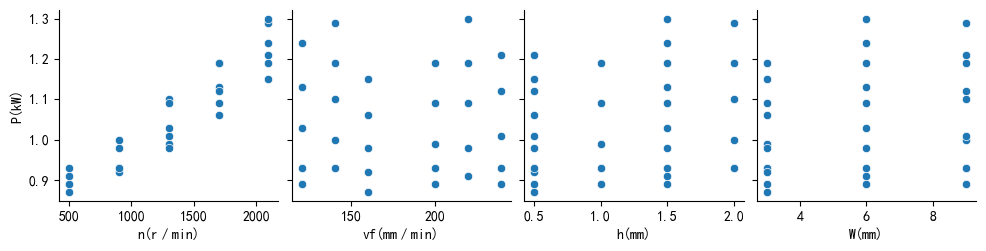

In [145]:
#观察各个feature与P(W)的关系
import seaborn as sns
sns.pairplot(data, x_vars=list(data.columns)[:-1], y_vars=list(data.columns)[-1])


In [146]:
a = np.array([1,2,3,4,5])
np.std(a)

1.4142135623730951

In [147]:
#搭建模型网络
class Pw_Model(nn.Module):
    def __init__(self, input_dim):
        super(Pw_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)  # (B, 1) -> (B)
        return x
    
#数据加载转换tensor类
class Pw_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [148]:
#hyperparameters配置
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'n_epochs': 1000,     # Number of epochs.
    'batch_size': 256,
    'learning_rate': 1e-4,
}


In [149]:
#标准化操作示例
data_normalized = data
data_normalized.apply(lambda x: (x - np.mean(x)) / (np.std(x)))


,n(r／min),vf(mm／min),h(mm),W(mm),P(kW)
0,-1.414214,-0.92582,1.507557,1.224745,-0.921885
1,-0.707107,-0.92582,1.507557,1.224745,-0.373455
2,0.000000,-0.92582,1.507557,1.224745,0.410017
3,0.707107,-0.92582,1.507557,1.224745,1.115141
4,1.414214,-0.92582,1.507557,1.224745,1.898612
5,-1.414214,-1.38873,0.603023,0.000000,-1.235273
6,-0.707107,-1.38873,0.603023,0.000000,-0.921885
7,0.000000,-1.38873,0.603023,0.000000,-0.138413
8,0.707107,-1.38873,0.603023,0.000000,0.645058
9,1.414214,-1.38873,0.603023,0.000000,1.506877


In [150]:
#初始化数据
#打乱
data = data.sample(frac=1.0)
#标准化(理论上先划分再归一化，这里偷懒了，对于data_1不归一化效果也很好，因为已经做过量纲处理了)
data_normalized = data.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
#划分训练集和验证集
divide = int(data.shape[0]*0.85)
train_data, test_data = data_normalized.iloc[:divide], data_normalized.iloc[divide:data.shape[0]]
train_data, test_data = train_data.values,test_data.values

train_y , test_y = train_data[:,-1],test_data[:,-1]
train_x , test_x = train_data[:,:-1],test_data[:,:-1]

train_dataset, test_dataset = Pw_Dataset(
    train_x, train_y), Pw_Dataset(test_x, test_y)
train_loader = DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)


In [151]:
#优化函数，损失函数，数据迁移
model = Pw_Model(input_dim=train_x.shape[1]).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(
    model.parameters(), lr=config['learning_rate'])



In [152]:
#训练
def trainer(train_loader, model, config, device):
    n_epochs,step = config['n_epochs'],0
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, leave=False)
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            # Compute gradient(backpropagation).
            loss.backward()
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
        mean_train_loss = sum(loss_record)/len(loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss: .8f}')
    return loss_record


In [153]:
#测试
def test(test_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    loss_record = []
    predict = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            predict.append(pred)
            loss = criterion(pred, y)
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    with open("./renderings/test_score.txt", "a") as file:
        file.write(figurename[number]+"模型\n")
        file.write(f'test loss: {mean_test_loss:.8f}\n')
    return predict


Epoch[50/1000]: Train loss:  0.88036937


Epoch[100/1000]: Train loss:  0.64023430


Epoch[150/1000]: Train loss:  0.46252317


Epoch[200/1000]: Train loss:  0.35421568


Epoch[250/1000]: Train loss:  0.28599435


Epoch[300/1000]: Train loss:  0.23953022


Epoch[350/1000]: Train loss:  0.20592630


Epoch[400/1000]: Train loss:  0.18052081


Epoch[450/1000]: Train loss:  0.16065353


Epoch[500/1000]: Train loss:  0.14470460


Epoch[550/1000]: Train loss:  0.13162645


Epoch[600/1000]: Train loss:  0.12071115


Epoch[650/1000]: Train loss:  0.11146455


Epoch[700/1000]: Train loss:  0.10353190


Epoch[750/1000]: Train loss:  0.09665222


Epoch[800/1000]: Train loss:  0.09062914


Epoch[850/1000]: Train loss:  0.08531223


Epoch[900/1000]: Train loss:  0.08058425


Epoch[950/1000]: Train loss:  0.07635252


Epoch[1000/1000]: Train loss:  0.07254284


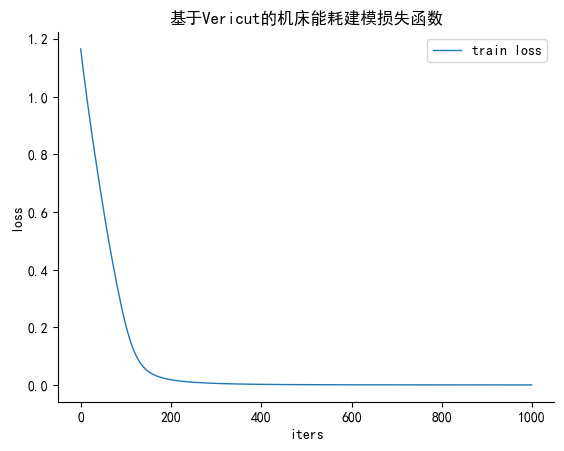

In [154]:
y_train_loss = trainer(train_loader, model, config, device)      # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,
         linestyle="solid", label="train loss")
plt.legend()
plt.title(figurename[number]+"损失函数")
plt.savefig("./renderings/"+figurename[number]+"损失函数")
plt.show()


In [155]:
predict = test(test_loader,model,device)
predict

[tensor([-1.4225,  0.4517,  0.0635, -0.1504,  1.2085], device='cuda:0')]

In [156]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs/

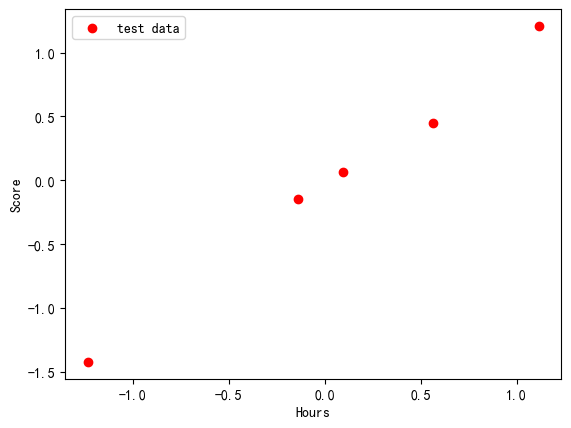

0.9811311986563273


In [157]:
from sklearn.metrics import r2_score
real= np.array(test_y)
compute = predict[0].cuda().cpu().numpy()
#测试数据散点图
plt.scatter(real, compute, color='red', label="test data")
#添加图标标签
plt.legend(loc=2)
plt.xlabel("Hours")
plt.ylabel("Score")
#显示图像
save_fig = "./score/"+figurename[number]
plt.savefig(save_fig+"score")
plt.show()
#计算拟合优度
score = r2_score(real, compute)
print(score)


In [158]:
save_name = "./save/"+str[number]+".pt"
torch.save(model, save_name)
